In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 1
%aimport models
%aimport main
%aimport data_utils
%aimport contrastive_data
%aimport scoring

In [3]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *
from glob import glob

# Data and model

In [4]:
GENE = 'KRAS'
data_path = f'/home/lguirardel/data/perturb_comp/data/{GENE}/'


In [5]:
# Most common mutations in TP53 and KRAS according to TCGA
if GENE == 'TP53':
    MAIN_MUTANTS = ['WT', 'L344L','R175H', 'R248Q','R273C','R273H','R248W', 'R282W','Y220C','G245S','H179R',] # L344L added bc WT has a low number of cells
elif GENE == 'KRAS':
    MAIN_MUTANTS = ['WT','G12D','G12V','G12C','G13D','G12A','G12R', 'G12S', 'A146T','G13C', ]

VFC_KEY = {'Impactful I':0, 'Impactful II':1, 'Impactful III':2, 'Impactful IV':3, 'WT-like':-1, 'Synonymous':-2} # to sort genes by variant functional class

In [6]:
group_wt_like = False
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=group_wt_like)

	Reading files...
		Reading matrix
		Reading genes and cells
		Reading variant data
	Merging and processing...
		97 variant classes


In [7]:
variant_data = pd.read_csv(paths[4], index_col=0)
variant_data.loc['control'] = pd.Series({'Control status':'synonymous','Variant functional class':'WT-like'})
variant_data['Variant functional class'] = variant_data['Variant functional class'].replace({'Impactful IV (gain-of-function)':'Impactful IV'})

In [8]:
with gzip.open(paths[3]) as file: # read cell tags
    v2c = pd.read_csv(file, sep='\t', usecols=['cell','variant'], index_col=1).squeeze()
v2c = v2c[counts.index]
v2c.shape

(87262,)

In [9]:
counts.groupby('variant').size().mean()

899.6082474226804

## Run from here to re-split without reloading all data

(will be necessary if wtlike is changed however)

In [10]:
#CELL TO CHANGE
run_name = 'KRAS_all_single_71'
run_dir = 'KRAS_all_single/KRAS_all_single_71'
BAG_SIZE = 50
dir_name = join('models',run_dir)
dataset_class = BatchDataset
! cat models/{run_dir}/config.ini

dest-name = KRAS_all_single
verbose = 1
load-split = KRAS_all_single/KRAS_all_single_0
loss = standard
dropout = 0.15009970712995122
weight-decay = 0.5720538547190746
batch-size = 512
positive-fraction = 0.4406668002267212
shape = [827, 827, 827]
embed-dim = 20
lr = 0.000929046000910132
scheduler = restarts
patience = 481
cosine-t = 587
task = classifier
margin = 1
alpha = 0
n-epochs = 600
knn = 5
bag-size = 0
mil-mode = attention
n-workers = 0


In [11]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, )
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

AttributeError: 'DataFrame' object has no attribute 'subset'

In [ ]:
n_mut = len([v for v in df_train['variant'].unique() if v in MAIN_MUTANTS])
print(f"Number of top {len(MAIN_MUTANTS)} variants in training set: {n_mut}")

Number of top 11 variants in training set: 8


In [ ]:
# obsolete - all runs should be grouped by control now
# print(run_name)
# group_original = True
# if ('control' == df_train.variant).any():
#     if  ('control' == df_unseen.variant).any():
#         print('WT-like not merged together in original data')
#         group_original = False
#     else:
#         print('WT-like merged together in original data, put in train/seen')
# else:
#     print('WT-like merged together in original data, put in unseen')

# print(f"{group_wt_like=}")

# if group_original ^ group_wt_like: # xor
#     raise ValueError(f'The data used to trained the model was {"not " if not group_original else ""}grouped \
#                      and the data now is {"not " if not group_wt_like else ""}grouped') 


In [ ]:
dl_train, dl_seen, dl_unseen = make_loaders(
    df_train, df_seen,df_unseen, batch_size=64, dataset_class=dataset_class,n_workers=1,pos_frac=0.5, 
    dataset_kwargs={'bag_size':BAG_SIZE})
dl_dict = {
    'train':dl_train,
    'seen':dl_seen,
    'unseen':dl_unseen,
}

In [ ]:
# model = torch.load(join(dir_name,'model.pkl'), map_location='cpu')
model :Model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')
model.eval()

Classifier(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=1224, out_features=718, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.3565534119325581, inplace=False)
      (3): Linear(in_features=718, out_features=718, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.3565534119325581, inplace=False)
      (6): Linear(in_features=718, out_features=718, bias=True)
      (7): ELU(alpha=1.0)
      (8): Dropout(p=0.3565534119325581, inplace=False)
      (9): Linear(in_features=718, out_features=718, bias=True)
      (10): ELU(alpha=1.0)
      (11): Dropout(p=0.3565534119325581, inplace=False)
      (12): Linear(in_features=718, out_features=20, bias=True)
    )
  )
  (output_layer): Linear(in_features=20, out_features=75, bias=True)
)

In [ ]:
!cat models/{run_dir}/best_score.json

{
  "5_nn_ref_seen": 0.029413609281906554,
  "i": 233
}

In [ ]:
fclass = variant_data.loc[df_seen.variant.unique(), 'Variant functional class']
fclass = fclass.where(fclass.index.map(lambda x :( x[0] != x[-1]) and (x!= 'WT')), 'Synonymous').sort_values(key=lambda s: s.map(VFC_KEY))

## Compute embeddings

TODO : this is way faster if done in one big batch

In [ ]:
emb_dict = {}
for k, df in df_dict.items():
    with torch.no_grad():
        X = torch.tensor(df.drop(columns=['variant','Variant functional class','cycle' ]).to_numpy(), dtype=torch.float32)[:, None, None, :] #(B, 1, 1, d)
        embeds = model.network.embed(X).squeeze()

    # emb_dict[k] = (embeds - embeds.mean(dim=0, keepdim=True)) / embeds.norm(dim=0, keepdim=True) # no : we want plots to represent distances in embed space 
    emb_dict[k] = embeds    

In [ ]:
emb_dict['train'].shape

torch.Size([47834, 20])

# Embed PCA

In [ ]:
pca = PCA(2).fit(emb_dict['seen'])

# Embedding distribution

In [ ]:
make_dir_if_needed(f'plots/embeds/{run_name}')

In [ ]:
hue_order = ['WT-like', 'Impactful I', 'Impactful II', 'Impactful III', 'Impactful IV']
if GENE == 'TP53':
    hue_order =  ['WT-like', 'Impactful I', 'Impactful II',] 

In [ ]:
subset = 'seen'
df = df_dict[subset]
embeds = emb_dict[subset]


emb_red = pca.transform(embeds)


In [ ]:
print(f'Explained variance : {(pca.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 36.2 %


In [ ]:
## SCATTER PLOT - VARIANT FUNCTIONAL CLASS
# sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], 
#                 hue_order=hue_order, alpha=0.01 if subset=='train' else 0.05, legend=False)
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], 
#             hue_order=hue_order, levels=3, common_norm=False, )
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_kde.pdf')

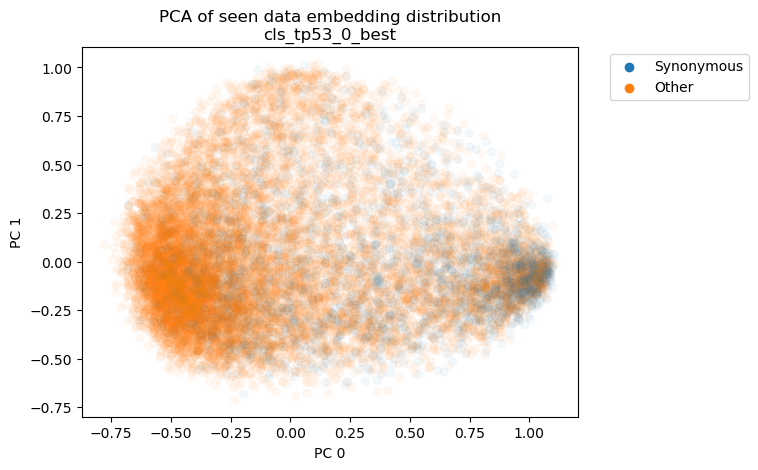

In [ ]:
## SCATTER PLOT - WT-SYN VS OTHERS
hue = df['variant'].apply(lambda x: 'Synonymous' if (x[0] ==x[-1] or x == 'WT') else 'Other')
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.01 if subset=='train' else 0.05, legend=True,
                edgecolor=None
                )
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
#             levels=5, common_norm=False, )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_syn.pdf')

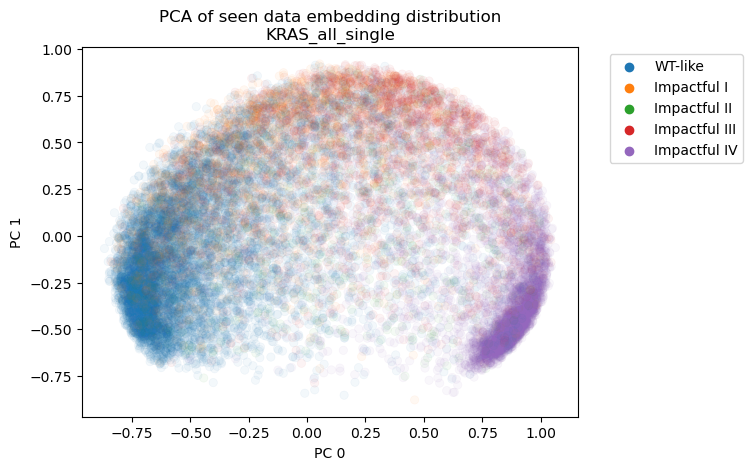

In [ ]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], 
                hue_order=hue_order, alpha=0.05, legend=True,
                # remove white border around markers
                edgecolor=None, linewidths=None
)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_scatter.pdf')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_scatter.png', dpi=600)



In [ ]:
var_avgs = []
for variant in df['variant'].unique():
        emb = emb_red[df['variant'] == variant].mean(0)
        var_avgs.append({'variant':variant, 'x':emb[0], 'y':emb[1]})
var_avgs = pd.DataFrame(var_avgs, )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


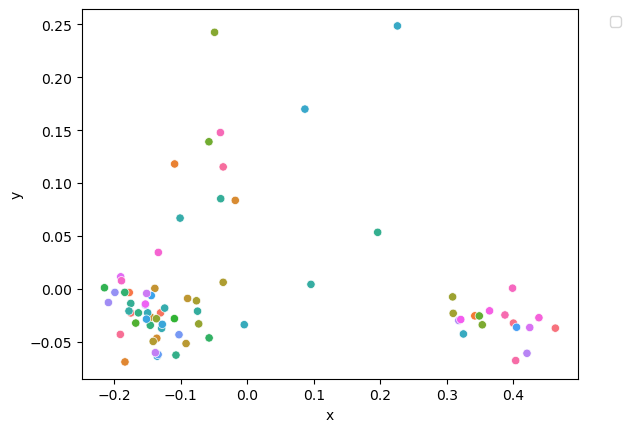

In [ ]:
sns.scatterplot(data=var_avgs, x='x', y='y', hue='variant', legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
df.variant.unique()

['P47P', 'R158R', 'G245D', 'H179Y', 'G245C', ..., 'R273L', 'G360V', 'E339K', 'R273H', 'C141Y']
Length: 75
Categories (99, object): ['E285K', 'C141Y', 'WT', 'E2E', ..., 'S366A', 'P47S', 'H214R', 'Q5R']

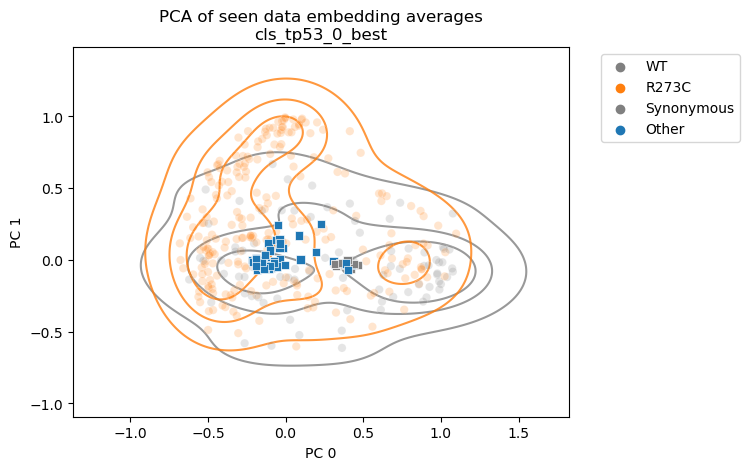

In [ ]:
variants = ['WT', 'R273C']
hue = df.variant.map(lambda x : x if x in variants else 'Other')

f = hue != 'Other'
sns.kdeplot(x=emb_red[f,0], y=emb_red[f,1], hue =hue[f], legend=False, common_norm=False, levels = 4,
            hue_order=variants, palette=['gray', 'C1'], alpha=0.8, 
            zorder=0 # put behind scatter plot
            )
hue = df.variant
sns.scatterplot(x=emb_red[f,0], y=emb_red[f,1], hue =hue[f],  alpha=0.2, legend=True,
            hue_order=variants,palette=['gray', 'C1']
            )

sns.scatterplot(x=var_avgs.x, y=var_avgs.y, 
    hue = var_avgs['variant'].map(lambda x : 'Synonymous' if fclass[x]=='Synonymous' else 'Other'), palette=['gray', 'C0'],
    #   label='Variant average (all variants)', color='C0' ,
      marker='s',
      legend=True, 
    #   edgecolor='black',
)


plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding averages\n{run_name}' )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_averages.pdf')

In [ ]:
f = df['Variant functional class'] == 'Impactful IV'
sns.scatterplot(x=emb_red[f,0], y=emb_red[f,1], hue = df.loc[f,'variant'].to_numpy(), alpha=0.1, legend=True)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )

NameError: name 'df' is not defined

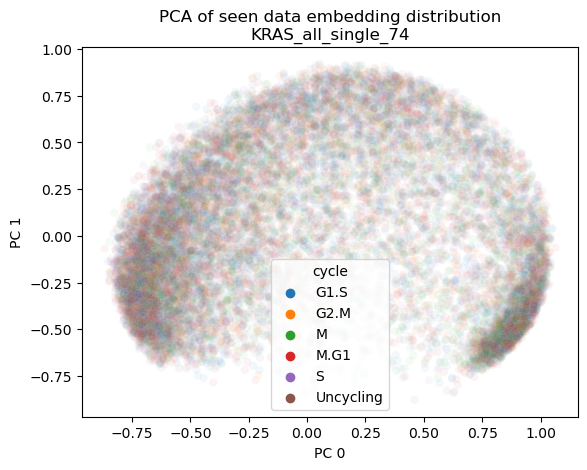

In [ ]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['cycle'], 
                 alpha=0.05, legend=True)


plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_cycle_pca_scatter.pdf')

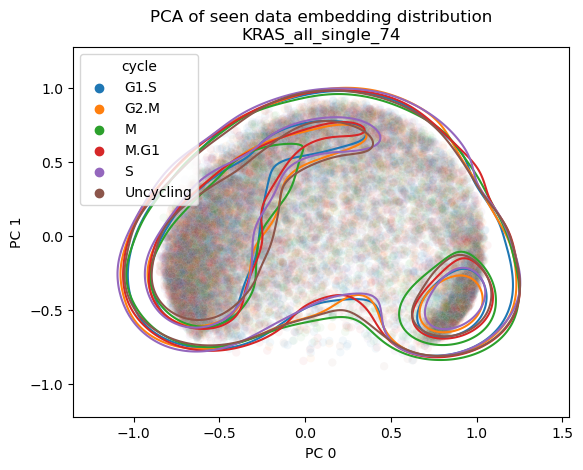

In [ ]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['cycle'], 
                 alpha=0.05, legend=True)
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['cycle'], 
             levels=3, common_norm=False, legend=False )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_cycle_pca_kde.pdf')

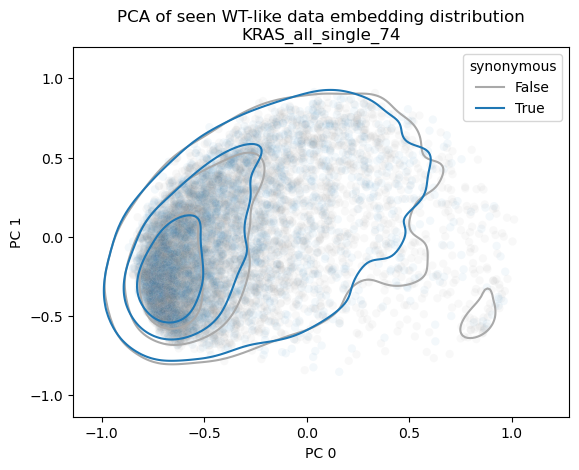

In [ ]:
f = df['Variant functional class'] == 'WT-like'
df2 = df[f]
if subset == 'test_unseen':
    df2 = pd.concat((df2, ))
hue = pd.merge(df2, left_on='variant',right=variant_data, right_index=True, how='left')['Control status'] == 'synonymous'
sns.scatterplot(x=emb_red[f,0], y=emb_red[f,1], hue =hue.rename('synonymous'), palette={True:'C0',False:'grey'}, alpha=0.05, legend=False)
sns.kdeplot(x=emb_red[f,0], y=emb_red[f,1],  hue =hue.rename('synonymous'), palette={True:'C0',False:'darkgrey'}, levels=4, common_norm=False, legend = True)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} WT-like data embedding distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_wtlike_embed_pca_kde.pdf')

In [ ]:
[v for v  in MAIN_MUTANTS if v  in  df.variant.unique()]

['WT', 'G12D', 'G12V', 'G12R', 'A146T']

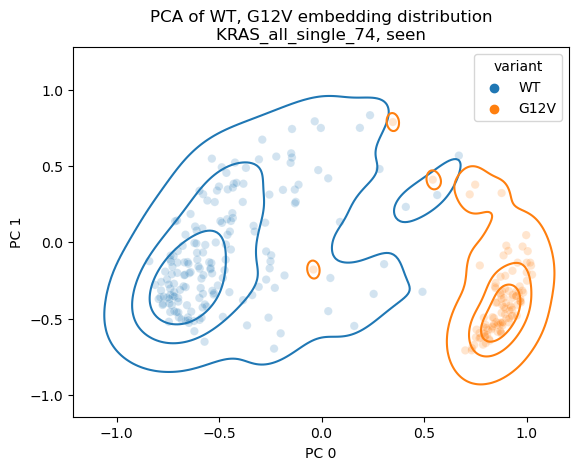

In [ ]:
variants = ['WT', 'G12V']
# variant = 'C277F'
# df2 = df[f]
# variant_list = df2.variant.unique()

hue = df.variant.map(lambda x : x if x in variants else 'Other')

f = hue != 'Other'
sns.kdeplot(x=emb_red[f,0], y=emb_red[f,1], hue =hue[f], legend=False, common_norm=False, levels = 4,
            hue_order=variants)
hue = df.variant
sns.scatterplot(x=emb_red[f,0], y=emb_red[f,1], hue =hue[f],  alpha=0.2, legend=True,
            hue_order=variants
            )



plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {", ".join(variants)} embedding distribution\n{run_name}, {subset}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_variants_embed_pca_kde.pdf')
# plt.title('Classifier model')

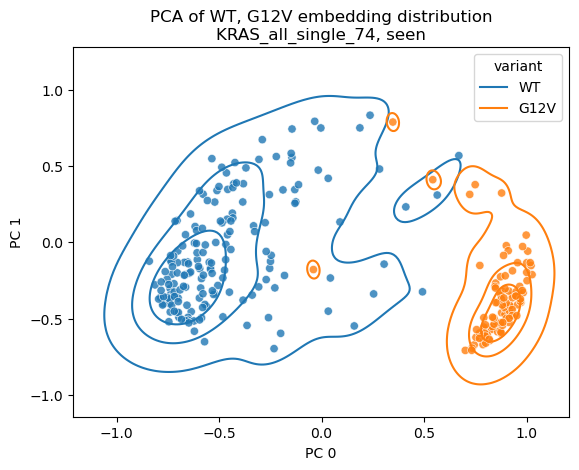

In [ ]:
sns.scatterplot(x=emb_red[f,0], y=emb_red[f,1], hue =hue[f],  alpha=0.8, legend=False,
            hue_order=variants)

sns.kdeplot(x=emb_red[f,0], y=emb_red[f,1], hue =hue[f], legend=True, common_norm=False, levels = 4,
            hue_order=variants)

plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {", ".join(variants)} embedding distribution\n{run_name}, {subset}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_variants_pcaonly_kde.pdf')

In [ ]:
# f = pd.merge(df, variant_data, left_on='variant',right_index=True, how='left')['Control status'] == 'synonymous'
# df2 = df[f].copy()
# df2['variant'] = v2c
# sns.scatterplot(x=emb_red[f,0], y=emb_red[f,1], hue =df2.variant, alpha=0.05, legend=True)
# sns.kdeplot(x=emb_red[f,0], y=emb_red[f,1],  hue =df2.variant , levels=3, common_norm=False, legend = False)
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} synonymous variants embedding distribution\n{run_name}' )
# plt.savefig(f'plots/embeds/{run_name}/{subset}_synon_embed_pca_kde{"_nonorm" if not normalized else ""}.pdf')

In [ ]:
# variants = ['R110L', 'G245D', 'R213Q','R158H']


# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], levels=5, common_norm=False, legend=False,palette='gray')
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# for v in variants:
#     idx = (df['variant'] == v).to_numpy()
#     plt.scatter(x=emb_red[idx,0], y=emb_red[idx,1],label=v, marker='x',alpha=0.5)
# plt.legend()

# Well-located genes

Develop a metric for genes that are well separated from others ? Just see confusion matrix tbh.
Otherwise, size of std ellipse ? Size of std ellipse + intersection with others ?

candidates : C277F

# Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
make_dir_if_needed(f'plots/clustering/{run_name}')

## KMEANS clustering of embeddings

### Evaluate number of clusters

In [ ]:
emb_dict['seen'].shape

torch.Size([15945, 20])

In [ ]:
s = []
c = []
for i in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters=i)
    labels = kmeans.fit_predict(emb_dict['seen'])
    s.append(silhouette_score(emb_dict['seen'], labels))
    c.append(kmeans.inertia_)


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


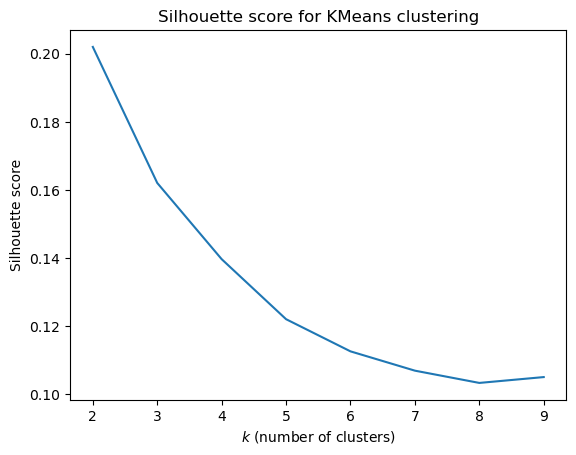

In [ ]:
plt.plot(range(2,len(s)+2),s)
plt.title('Silhouette score for KMeans clustering')
plt.xlabel('$k$ (number of clusters)')
plt.ylabel('Silhouette score')
plt.savefig(f'plots/clustering/{run_name}/silhouette_score.pdf')

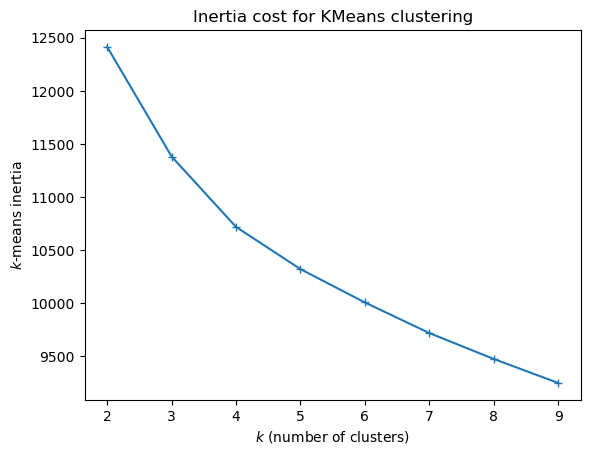

In [ ]:
plt.plot(range(2,len(c)+2),c, '+-')
plt.title('Inertia cost for KMeans clustering')
plt.xlabel('$k$ (number of clusters)')
plt.ylabel('$k$-means inertia')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_inertia.pdf')

... Silhouette would say no clusters, so we're going to use elbow inertia, and choose 4 clusters 

KRAS MIL : Silhouette says 4 ! Not MIL : rather 3

### Plot cluster

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=4)
labels = kmeans.fit_predict(emb_dict['seen'])
emb_red = pca.transform(emb_dict['seen'])


In [ ]:
### CHANGE OR DELETE DEPENDING ON CLUSTER ORDER
perm = np.array([1,0,3,2])
labels = perm[labels]

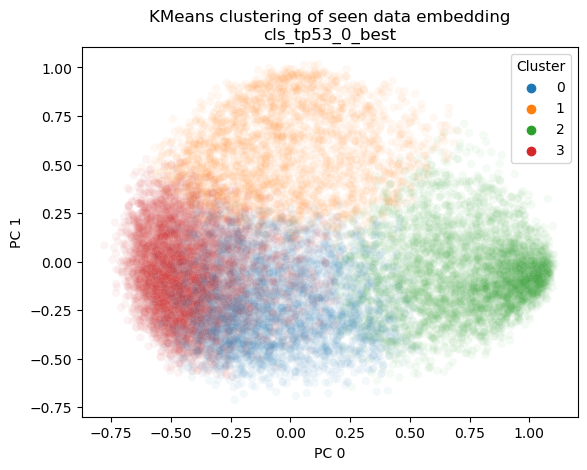

In [ ]:
# scatter plot
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = labels, palette='tab10', alpha=0.05, legend=True)
plt.legend(title='Cluster')
plt.title(f'KMeans clustering of seen data embedding\n{run_name}')
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
# legend outside plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_kmeans_scatter.pdf')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_kmeans_scatter.png', dpi=600)


/tmp/ipykernel_74177/1510563713.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=emb_red[filt,0], y=emb_red[filt,1], hue = labels[filt], palette='tab10', alpha=0.8,


Text(0, 0.5, 'PC 1')

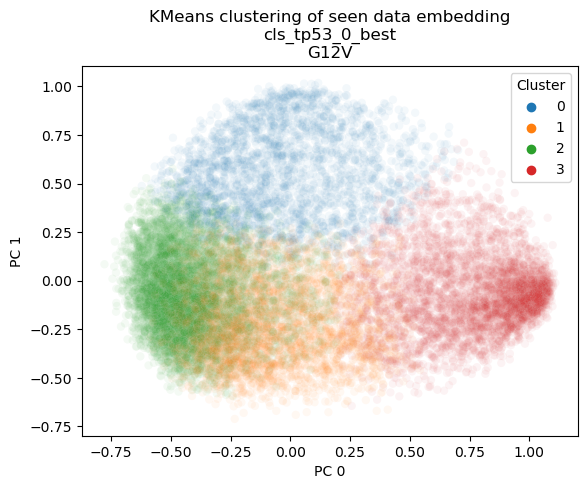

In [ ]:
# scatter plot
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = labels, palette='tab10', alpha=0.05, legend=True)

variant = 'G12V'
filt = df_seen.variant.isin([variant])
sns.scatterplot(x=emb_red[filt,0], y=emb_red[filt,1], hue = labels[filt], palette='tab10', alpha=0.8,
                 legend=False, hue_order=range(k))
plt.legend(title='Cluster')
plt.title(f'KMeans clustering of seen data embedding\n{run_name}\n{variant}')
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
# plt.savefig(f'plots/clustering/{run_name}/{run_name}_{variant}_kmeans_scatter.pdf')

In [ ]:
MAIN_MUTANTS_2 = ['K169K','V14L','G13C','G13R']

In [ ]:
main_var_only = False # set to False to include all variants
# Create a dataframe with cluster labels and variant names
df_heatmap = pd.DataFrame({'Cluster': labels, 'Variant': df_seen['variant']})


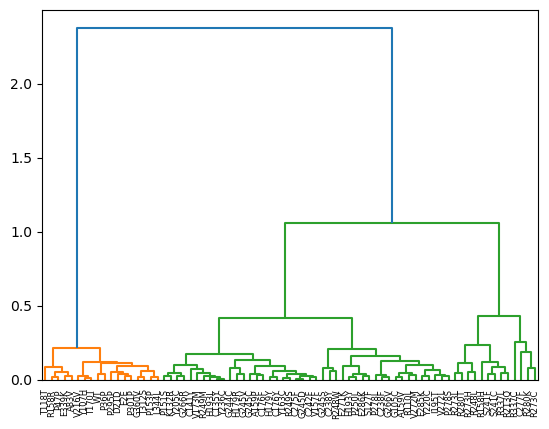

In [ ]:
# HIERARCHICAL  CLUSTERING SORTING
prop = df_heatmap.groupby('Variant').value_counts() / df_heatmap['Variant'].value_counts()
prop = prop.dropna().unstack() # remove variants that are not in the data 
hierarchical = AgglomerativeClustering(n_clusters=4,compute_distances=True).fit(prop)
# Create linkage matrix and then plot the dendrogram

# create the counts of samples under each node
n_samples = len(hierarchical.labels_)
c = np.zeros(hierarchical.children_.shape[0])
n_samples = len(hierarchical.labels_)
for i, merge in enumerate(hierarchical.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += c[child_idx - n_samples]
    c[i] = current_count

linkage_matrix = np.column_stack(
    [hierarchical.children_, hierarchical.distances_, c]
).astype(float)

# Plot the corresponding dendrogram
order = dendrogram(linkage_matrix, labels=prop.index )['ivl']

In [ ]:
order[-4:]

['R337C', 'C277F', 'R280K', 'R273C']

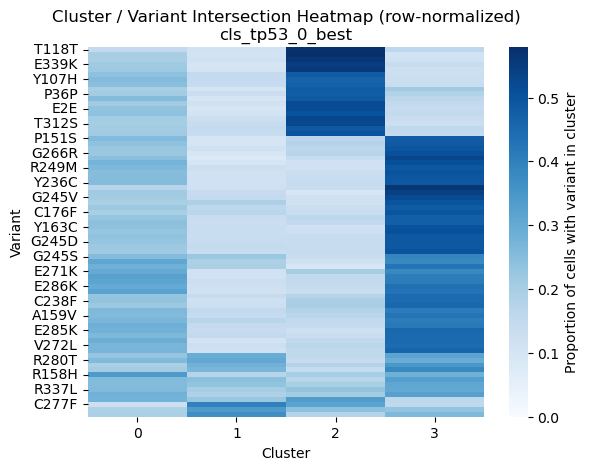

In [ ]:
# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Variant', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) # normalize by row
# heatmap_data = heatmap_data.reindex(fclass.index)
heatmap_data = heatmap_data.loc[order]

if main_var_only:
    heatmap_data = heatmap_data[heatmap_data.index.isin(MAIN_MUTANTS)]


# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0,
                      )
heatmap.set_title('Cluster / Variant Intersection Heatmap (row-normalized)\n'+run_name)
heatmap.set_xlabel('Cluster')
heatmap.set_ylabel('Variant')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells with variant in cluster')

# Add annotations to the heatmap
if main_var_only:
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            value = heatmap_data.iloc[i, j]
            heatmap.annotate(f'{value:.2f}', (j + 0.5, i + 0.5), ha='center', va='center',
                            color = 'black' if value < cbar.vmax/2 else 'white'
                            )
plt.savefig(f'plots/clustering/{run_name}/{run_name}_cluster_variant_heatmap_row{"_variants" if main_var_only else "" }.pdf')


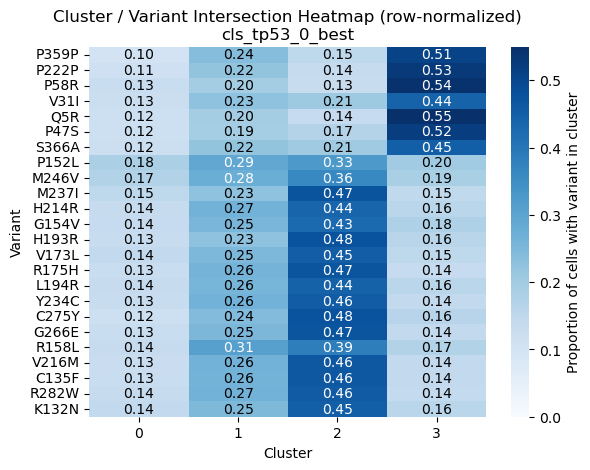

In [ ]:
# IDEM BUT FOR UNSEEN VARIANTS

main_var_only = False # set to False to include all variants
# Create a dataframe with cluster labels and variant names
labels_unseen = kmeans.predict(emb_dict['unseen'])
df_heatmap = pd.DataFrame({'Cluster': labels_unseen, 'Variant': df_unseen['variant']})
fclass_unseen = variant_data.loc[df_unseen.variant.unique(), 'Variant functional class']
fclass_unseen = fclass_unseen.where(fclass_unseen.index.map(lambda x :( x[0] != x[-1]) and (x!= 'WT')), 'Synonymous').sort_values(key=lambda s: s.map(VFC_KEY))
# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Variant', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) # normalize by row
heatmap_data = heatmap_data.reindex(fclass_unseen.index)

if main_var_only:
    heatmap_data = heatmap_data[heatmap_data.index.isin(MAIN_MUTANTS+MAIN_MUTANTS_2)]


# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0,
                      )
heatmap.set_title('Cluster / Variant Intersection Heatmap (row-normalized)\n'+run_name)
heatmap.set_ylabel('Variant')
heatmap.set_xlabel('Cluster')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells with variant in cluster')

# Add annotations to the heatmap
# if main_var_only:
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        value = heatmap_data.iloc[i, j]
        if value > 0.05:
            heatmap.annotate(f'{value:.2f}', (j + 0.5, i + 0.5), ha='center', va='center',
                            color = 'black' if value < cbar.vmax/2 else 'white'
                            )
plt.savefig(f'plots/clustering/{run_name}/{run_name}_cluster_variant_heatmap_row_unseen{"_variants" if main_var_only else "" }.pdf')

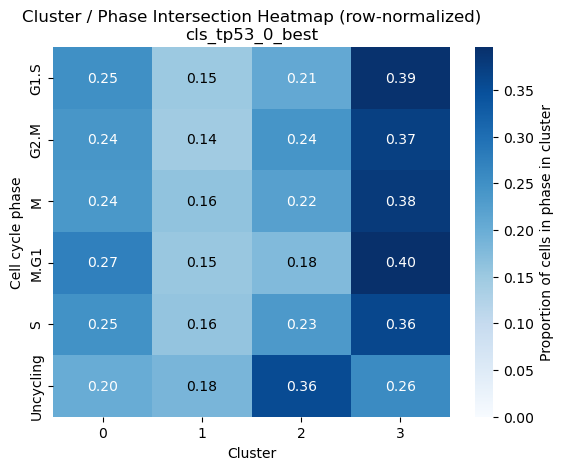

In [ ]:
# Create a dataframe with cluster labels and cell cycle
df_heatmap = pd.DataFrame({'Cluster': labels, 'Phase': df_seen['cycle']})

# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Phase', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) # normalize by row

# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0,
                      )
heatmap.set_title('Cluster / Phase Intersection Heatmap (row-normalized)\n'+run_name)
heatmap.set_xlabel('Cluster')
heatmap.set_ylabel('Cell cycle phase')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells in phase in cluster')

# Add annotations to the heatmap
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        value = heatmap_data.iloc[i, j]
        heatmap.annotate(f'{value:.2f}', (j + 0.5, i + 0.5), ha='center', va='center',
                        color = 'black' if value < cbar.vmax/2 else 'white'
                        )
plt.savefig(f'plots/clustering/{run_name}/{run_name}_cluster_cycle_heatmap.pdf')


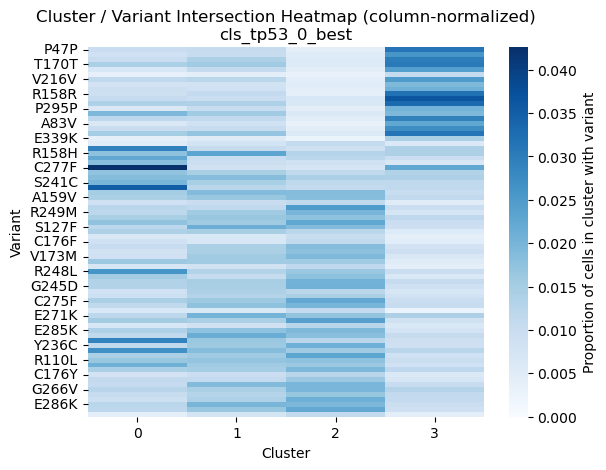

In [ ]:
# same thing but column-normalized
# Create a dataframe with cluster labels and variant names
df_heatmap = pd.DataFrame({'Cluster': labels, 'Variant': df_seen['variant']})

# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Variant', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) # normalize by column
heatmap_data = heatmap_data.loc[fclass.index]

# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0)
heatmap.set_title('Cluster / Variant Intersection Heatmap (column-normalized)\n'+run_name)
heatmap.set_ylabel('Variant')
heatmap.set_xlabel('Cluster')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells in cluster with variant')


plt.savefig(f'plots/clustering/{run_name}/cluster_variant_heatmap_column.pdf')

## Same but DBSCAN

In [ ]:
raise RuntimeError('Stop here')

RuntimeError: Stop here

In [ ]:
s = []
c = []
eps = np.logspace(-4, 0, 500)
for i in tqdm(eps):
    kmeans = DBSCAN(eps=i)
    labels = kmeans.fit_predict(emb_dict['seen'])
    n = np.unique(labels[labels>=0]).size # account for case 1 label + excluded
    if n > 1: 
        s.append(silhouette_score(emb_dict['seen'][labels >=0], labels[labels>=0]))
    else:
        s.append(0)
    c.append(n)


  1%|          | 4/500 [00:01<02:02,  4.05it/s]

100%|██████████| 500/500 [02:03<00:00,  4.06it/s]


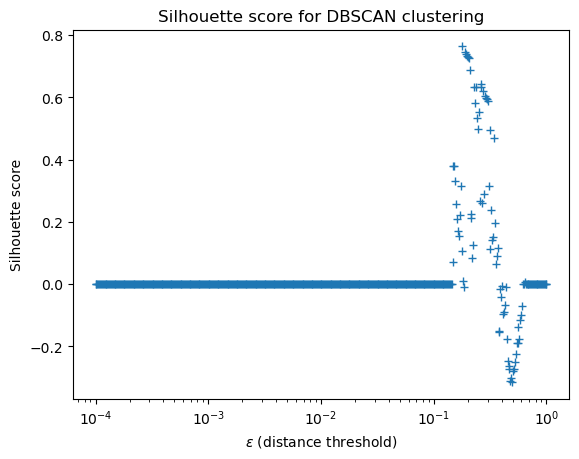

In [ ]:
plt.plot(eps,s, '+')
plt.title('Silhouette score for DBSCAN clustering')
plt.xlabel('$\\varepsilon$ (distance threshold)')
plt.ylabel('Silhouette score')
plt.xscale('log')
plt.savefig(f'plots/clustering/{run_name}/DBSCAN_silhouette_score.pdf')

Text(0, 0.5, 'Distance')

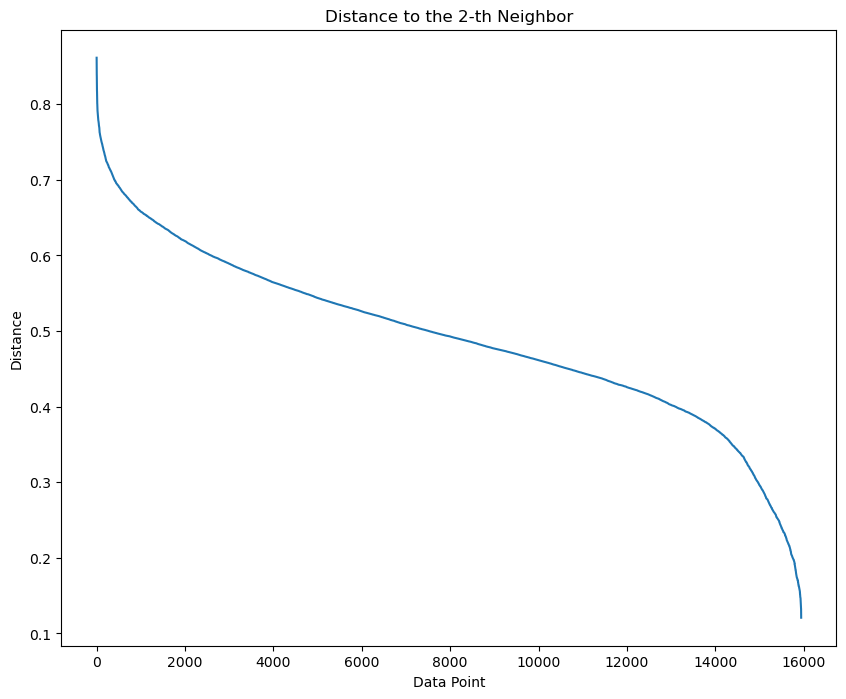

In [ ]:
from sklearn.neighbors import kneighbors_graph

# Compute the k-nearest neighbors graph
k = 2  # Set the value of k
distances = kneighbors_graph(emb_dict['seen'], k, mode='distance')

# Plot the distance to the k-th neighbor
plt.figure(figsize=(10, 8))
D =  np.sort(distances.toarray().max(axis=1) )[::-1]
# D = D[:500]
plt.plot(range(len(D)),D)
plt.title(f'Distance to the {k}-th Neighbor')
plt.xlabel('Data Point')
plt.ylabel('Distance')
# plt.savefig('distance_to_kth_neighbor.png')
# plt.show()


In [ ]:
d = distances.toarray()
d[d>0]=1
d.sum(axis=0)

array([3., 3., 8., ..., 2., 8., 4.])

In [ ]:
np.sort(distances.toarray())[:, -1]

array([0.72819586, 0.72319258, 0.49798637, ..., 0.62248408, 0.56263292,
       0.56793598])

Text(0, 0.5, 'Number of clusters')

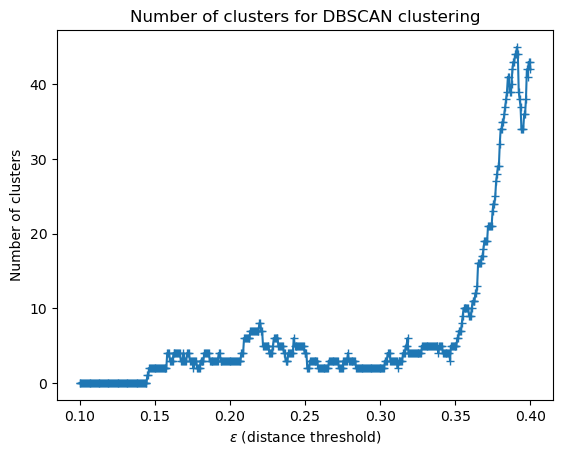

In [ ]:
plt.plot(eps,c, '-+')
plt.title('Number of clusters for DBSCAN clustering')
plt.xlabel('$\\varepsilon$ (distance threshold)')
plt.ylabel('Number of clusters')

### Plotting

In [ ]:
eps = 0.25
kmeans = DBSCAN(eps=eps)
labels = kmeans.fit_predict(emb_dict['seen'])
emb_red = pca.transform(emb_dict['seen'])
np.unique(labels)

array([-1,  0,  1,  2,  3])

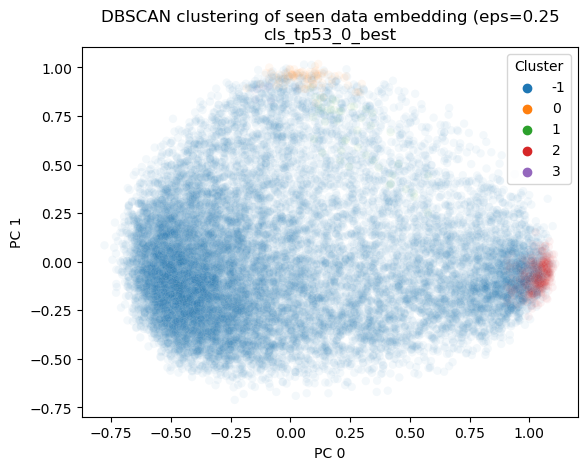

In [ ]:
# scatter plot
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = labels,  palette='tab10',alpha=0.05, legend=True)
plt.legend(title='Cluster')
plt.title(f'DBSCAN clustering of seen data embedding ({eps=}\n{run_name}')
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_DBSCAN_scatter.pdf')

Not worth it apparently

## Same but Louvain

In [ ]:
import networkx as nx
from sklearn.neighbors import kneighbors_graph

In [ ]:
G = nx.from_numpy_array(kneighbors_graph(emb_dict['seen'], 20, mode='distance').toarray()) # Seurat default is 20
n_cells = len(emb_dict['seen'])


In [ ]:
s = []
n_c = []
resolution = np.linspace(0.2, 1.5, 10)
for r in tqdm(resolution):
    clusters = nx.community.louvain_communities(G, resolution=r)
    labels = np.ones((n_cells,), dtype=int) * -1
    for i in range(n_cells):
        for j, c in enumerate(clusters):
            if i in c:
                labels[i] = j
                break
    s.append(silhouette_score(emb_dict['seen'], labels))
    n_c.append(len(clusters))

  0%|          | 0/10 [00:30<?, ?it/s]


KeyboardInterrupt: 

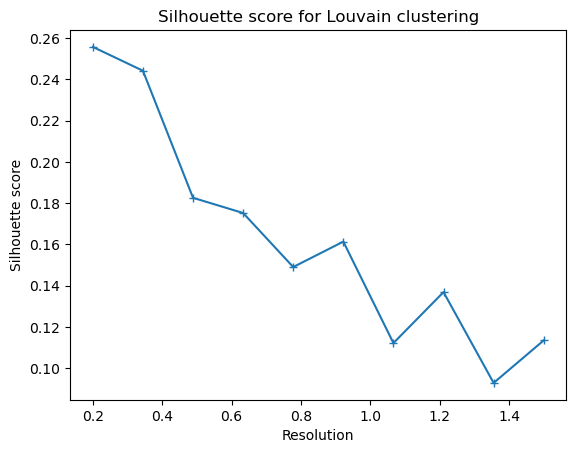

In [ ]:
plt.plot(resolution,s, "-+")
plt.title('Silhouette score for Louvain clustering')
plt.xlabel('Resolution')
plt.ylabel('Silhouette score')
plt.savefig(f'plots/clustering/{run_name}/Louvain_silhouette_score.pdf')

Text(0, 0.5, 'Number of clusters')

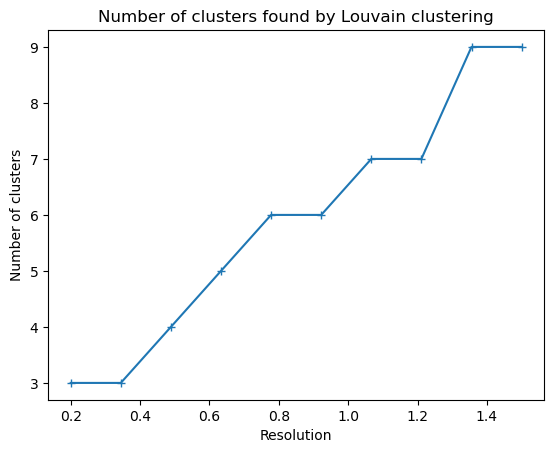

In [ ]:
plt.plot(resolution,n_c, '-+')
plt.title('Number of clusters found by Louvain clustering')
plt.xlabel('Resolution')
plt.ylabel('Number of clusters')
# plt.savefig(f'plots/clustering/{run_name}/Louvain_nclusters.pdf')

### Plot cluster

In [ ]:
r = 1
clusters = nx.community.louvain_communities(G, resolution=r, seed = 45)
labels = np.ones((n_cells,), dtype=int) * -1
for i in range(n_cells):
    for j, c in enumerate(clusters):
        if i in c:
            labels[i] = j
            break
emb_red = pca.transform(emb_dict['seen'])
labels = pd.Series(labels, name='Cluster', index=df_seen.index)

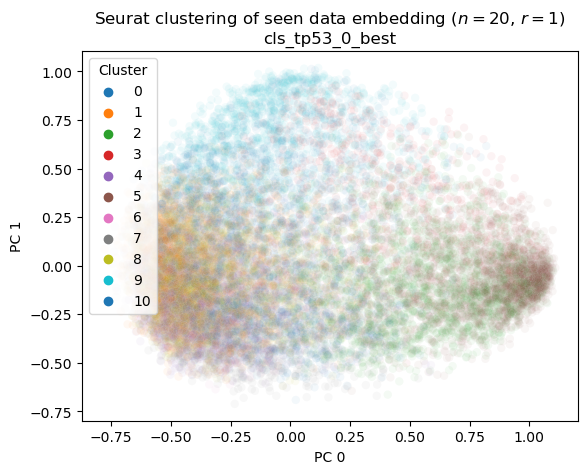

In [ ]:
# scatter plot
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = labels, palette='tab10', alpha=0.05, legend=True)
plt.legend(title='Cluster')
plt.title(f'Seurat clustering of seen data embedding ($n=20$, $r={r}$)\n{run_name}')
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_louvain_scatter.pdf')

In [ ]:
u,c = np.unique(labels, return_counts=True)
freq = pd.Series(c,index=u, name='count' ).sort_values(ascending=False)
freq = freq / freq.sum()
freq

5     0.143681
1     0.135466
8     0.128128
2     0.111007
4     0.086987
7     0.085481
0     0.084854
10    0.082847
9     0.068485
3     0.037629
6     0.035434
Name: count, dtype: float64

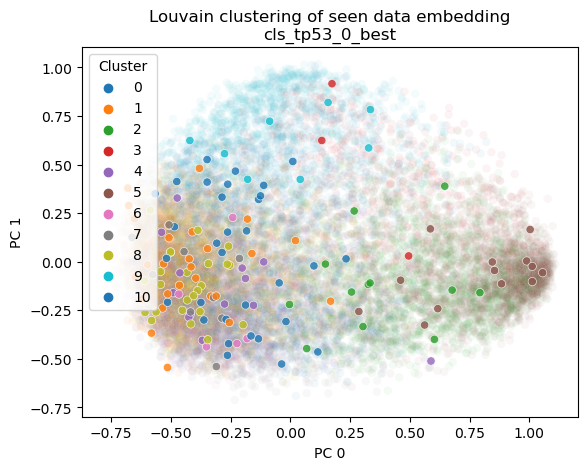

In [ ]:
# scatter plot
# filt  = labels.isin(freq[freq>0.1].index) # to keep only largest clusters. IDK if that makes sense
filt = pd.Series(True, index=labels.index)
sns.scatterplot(x=emb_red[filt,0], y=emb_red[filt,1], hue = labels[filt], palette='tab10', alpha=0.05, legend=True)

variant = 'Y220C'
filt = filt & df_seen.variant.isin([variant])
sns.scatterplot(x=emb_red[filt,0], y=emb_red[filt,1], hue = labels[filt], palette='tab10', alpha=0.8, legend=False)
plt.legend(title='Cluster')
plt.title(f'Louvain clustering of seen data embedding\n{run_name}')
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1');
# plt.savefig(f'plots/clustering/{run_name}/{run_name}_{variant}_louvain_scatter.pdf')

In [ ]:

fclass = variant_data.loc[df_seen.variant.unique(), 'Variant functional class']
fclass = fclass.where(fclass.index.map(lambda x :( x[0] != x[-1]) and (x!= 'WT')), 'Synonymous').sort_values(key=lambda s: s.map(VFC_KEY))

In [ ]:
tmp_mut = ['WT', 'L344L', 'R273C', 'Y220C']

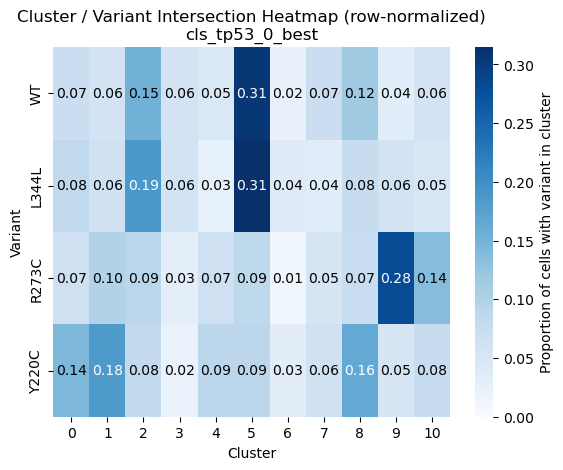

In [ ]:
main_var_only = True # set to False to include all variants
# Create a dataframe with cluster labels and variant names
df_heatmap = pd.DataFrame({'Cluster': labels, 'Variant': df_seen['variant']})

# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Variant', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) # normalize by row
heatmap_data = heatmap_data.reindex(fclass.index)

if main_var_only:
    heatmap_data = heatmap_data[heatmap_data.index.isin(tmp_mut)] # change to tmp_mut for fewer rows


# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0,
                      )
heatmap.set_title('Cluster / Variant Intersection Heatmap (row-normalized)\n'+run_name)
heatmap.set_ylabel('Variant')
heatmap.set_xlabel('Cluster')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells with variant in cluster')

# Add annotations to the heatmap
if main_var_only:
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            value = heatmap_data.iloc[i, j]
            if value >= 0.0:
                heatmap.annotate(f'{value:.2f}', (j + 0.5, i + 0.5), ha='center', va='center',
                                color = 'black' if value < cbar.vmax/2 else 'white'
                                )
plt.savefig(f'plots/clustering/{run_name}/{run_name}_louvain_variant_heatmap_row{"_variants" if main_var_only else "" }.pdf')


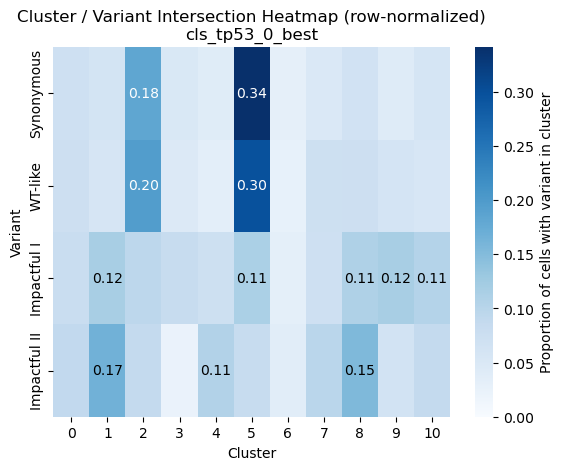

In [ ]:
# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Variant', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.groupby(fclass[heatmap_data.index]).sum()
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) # normalize by row
heatmap_data = heatmap_data.reindex(fclass.unique())

# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0,
                      )
heatmap.set_title('Cluster / Variant Intersection Heatmap (row-normalized)\n'+run_name)
heatmap.set_ylabel('Variant')
heatmap.set_xlabel('Cluster')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells with variant in cluster')

# Add annotations to the heatmap
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        value = heatmap_data.iloc[i, j]
        if value >= 0.1:
            heatmap.annotate(f'{value:.2f}', (j + 0.5, i + 0.5), ha='center', va='center',
                            color = 'black' if value < cbar.vmax/2 else 'white'
                            )
plt.savefig(f'plots/clustering/{run_name}/{run_name}_louvain_VFC_heatmap_row.pdf')


In [ ]:
heatmap_data

Cluster   0   1    2   3
Variant                 
E285K    26  37  150  31
C141Y     5  23   85   9
WT        4  41   27  13
E2E      18  98   44  17
V173M    18  33  146  21
...      ..  ..  ...  ..
S241C    19  44  105  50
A159V    17  47  154  30
R110L    18  51  135  42
V272M    27  51  147  31
V216V    12  94   62  27

[75 rows x 4 columns]

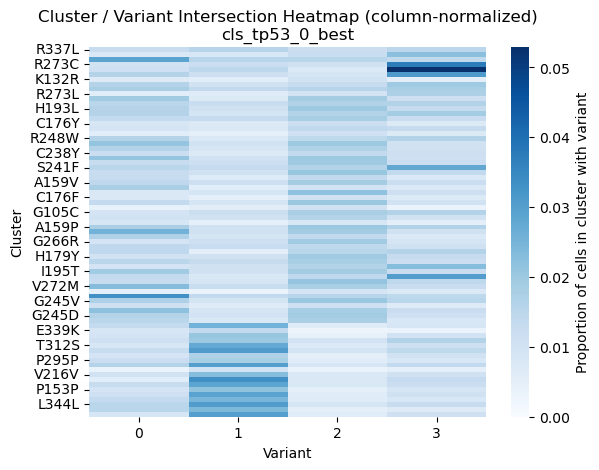

In [ ]:
# same thing but column-normalized


# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Variant', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) # normalize by column
heatmap_data = heatmap_data.loc[fclass.index]

# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0)
heatmap.set_title('Cluster / Variant Intersection Heatmap (column-normalized)\n'+run_name)
heatmap.set_xlabel('Variant')
heatmap.set_ylabel('Cluster')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells in cluster with variant')


plt.savefig(f'plots/clustering/{run_name}/louvain_variant_heatmap_column.pdf')

## Hierarchical clustering of variants

In [ ]:
subset = 'seen'
df = df_dict[subset]
embeds = emb_dict[subset]

emb_red = pca.transform(embeds)

In [ ]:
variant_avg = df.drop(columns=['Variant functional class','cycle']).groupby('variant').mean()
variant_avg = variant_avg.dropna() # drop variants in other part ofsplit

In [ ]:
correl = variant_avg.T.corr(method='spearman')

In [ ]:
clustering = AgglomerativeClustering(n_clusters= 3 if GENE == 'TP53' else 5, metric='l1',linkage='complete', compute_distances=True)
clusters = clustering.fit_predict(correl)

In [ ]:
clustering.distances_

array([ 2.8220051 ,  3.06817883,  3.13823627,  3.17044965,  3.41205437,
        3.41979136,  3.47469549,  3.50702108,  3.71369051,  3.75455391,
        3.86179254,  3.89914043,  3.94897915,  3.95696287,  3.97540059,
        4.06808415,  4.0752656 ,  4.1169186 ,  4.15234222,  4.15697559,
        4.17923447,  4.21083141,  4.21515658,  4.29850121,  4.30492966,
        4.30661842,  4.36738829,  4.38497104,  4.4092881 ,  4.43063733,
        4.43381358,  4.4441536 ,  4.50005451,  4.51673116,  4.52388911,
        4.52390916,  4.62300267,  4.63681321,  4.68419709,  4.70733784,
        4.74448919,  4.74820079,  4.7514416 ,  4.8509942 ,  4.85783695,
        5.01237534,  5.12058576,  5.20905535,  5.29192671,  5.39079338,
        5.39179368,  5.39209401,  5.43587184,  5.52182027,  5.66063223,
        5.7335709 ,  6.03594023,  6.16492461,  6.21775812,  6.3464499 ,
        6.38570715,  6.45695906,  6.51162607,  6.56158567,  6.64329072,
        6.84162333,  7.74559946,  9.20104595,  9.62330838,  9.97

In [ ]:


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

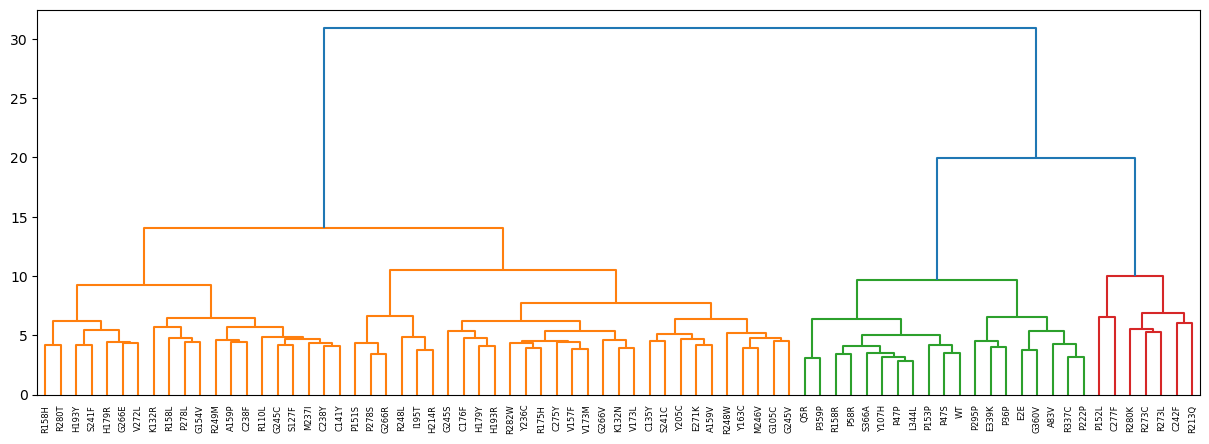

In [ ]:
plt.gcf().set_size_inches(15,5)
plot_dendrogram(clustering, color_threshold = clustering.distances_[-2], labels=correl.index, orientation='top' )

# Embedding PCA variance plot

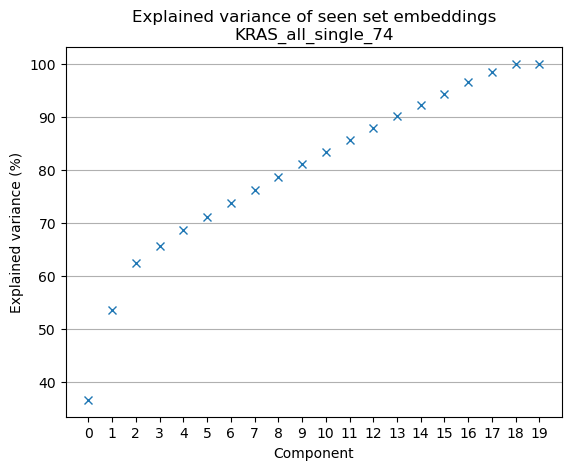

In [ ]:
subset='seen'
embeds = emb_dict[subset]

n = embeds.size(1)
embeds_norm = (embeds - embeds.mean(-1, keepdim=True))/embeds.std(-1, keepdim=True)
pca_2 = PCA(n).fit(embeds_norm)
plt.plot(range(n), 100* np.cumsum(pca_2.explained_variance_ratio_), 'x')
plt.ylabel('Explained variance (%)')
plt.xlabel('Component')
plt.title(f'Explained variance of {subset} set embeddings\n{run_name}')
plt.grid(axis='y')
plt.xticks(range(n))
plt.savefig(f'plots/embeds/{run_name}/embed_pca_variance.pdf');

# Comparison with simple PCA

In [ ]:
def normalize(df):
    return (df - df.mean())/df.std()

In [ ]:
subset = 'seen'
pca_base = PCA(2).fit(normalize(df_train.iloc[:,:-3]))

df = df_dict[subset]
X_red = pca_base.transform(normalize(df.iloc[:,:-3]))


In [ ]:
print(f'Explained variance : {(pca_base.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 5.1 %


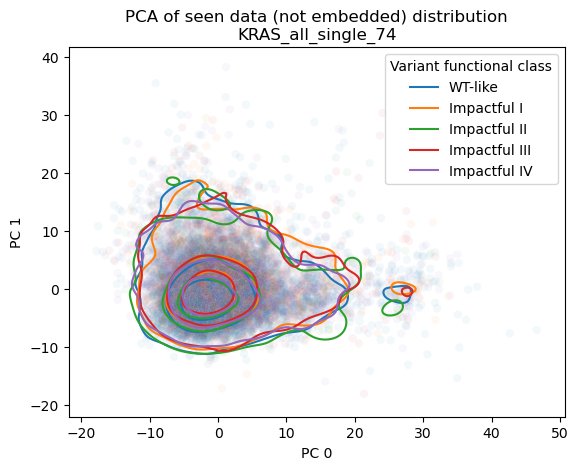

In [ ]:
sns.scatterplot(x=X_red[:,0], y=X_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, alpha=0.05, legend=False)
sns.kdeplot(x=X_red[:,0], y=X_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, levels=4, common_norm=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data (not embedded) distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_pca_kde.pdf')

Text(0.5, 1.0, 'PCA of WT, R273C embedding distribution\ncls_tp53_0_best, seen')

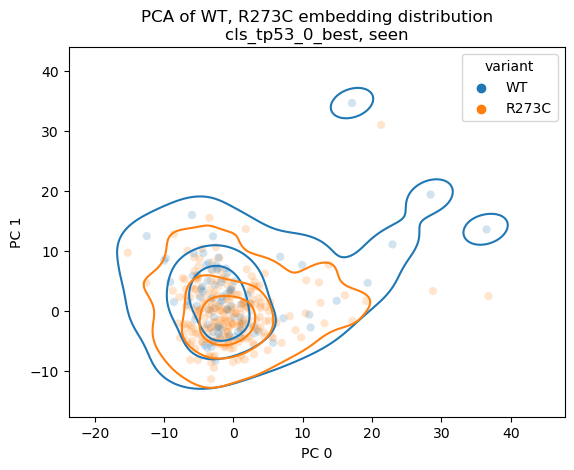

In [ ]:
variants = ['WT', 'R273C']
# variant = 'C277F'
# df2 = df[f]
# variant_list = df2.variant.unique()

hue = df.variant.map(lambda x : x if x in variants else 'Other')

f = hue != 'Other'

sns.kdeplot(x=X_red[f,0], y=X_red[f,1], hue =hue[f], legend=False, common_norm=False, levels = 4,
            hue_order=variants
            )

# hue = df['cycle'][f]
sns.scatterplot(x=X_red[f,0], y=X_red[f,1], hue =hue[f],  alpha=0.2, legend=True,
            hue_order=variants
            )



plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {", ".join(variants)} embedding distribution\n{run_name}, {subset}' )
# plt.savefig(f'plots/embeds/{run_name}/{subset}_variants_refpca_kde.pdf')

In [ ]:
df.iloc[:,:-3].std(axis=0).sort_values()

NTS              0.726865
RP11-338I21.1    0.735849
LINC01220        0.846769
SCG2             0.873338
VCAN             0.889288
                   ...   
CCL26            1.021527
FBXO32           1.021564
RTN2             1.025186
AC006262.5       1.035991
GACAT2           1.043334
Length: 1145, dtype: float64

# kNN scores

In [ ]:
make_dir_if_needed(f'plots/scores/{run_name}')

## ref knn

This score needs a reference (training) and a test set (seen)

In [ ]:
# identical to knn_ref_score but we want to keep predictions AND make a PCA of cells
# this is ref so unseen makes no sense
k=5
x_train = dl_train
x_test = dl_seen
model_ = model.network
device = 'cuda'
model_.eval()
model_ = model_.to(device)
emb_train, y_train = [], []
X_train = []
for x,y in x_train: # x,y are tuples of tensors of any size, we're taking the first one
    with torch.no_grad():
        emb_train.append(model_.embed(x[0].to(device)).cpu().squeeze())
        y_train.append(y[0])
        x0 = x[0].squeeze()
        if len(x0.shape) > 2: # 3D means bag of cells: we take the average
            x0 = x0.mean(1)
        X_train.append(x0)

emb_test, y_test, X_test = [], [], []
for x,y in x_test:
    with torch.no_grad():
        emb_test.append(model_.embed(x[0].to(device)).cpu().squeeze())
        y_test.append(y[0])
        x0 = x[0].squeeze()
        if len(x0.shape) > 2: # 3D means bag of cells: we take the average
            x0 = x0.mean(1)
        X_test.append(x0)

emb_train = torch.concat(emb_train)
emb_test = torch.concat(emb_test)
y_train = torch.concat(y_train)
y_test = torch.concat(y_test)
X_train = torch.concat(X_train)
X_test = torch.concat(X_test)
pca_cells =  PCA(20)
train_red = pca_cells.fit_transform(X_train)
test_red = pca_cells.transform(X_test)
knn = KNeighborsClassifier(k)
# model score
knn.fit(emb_train, y_train)
y_pred = knn.predict(emb_test)
s = accuracy_score(y_test, y_pred)
# PCA baseline
knn.fit(train_red, y_train)
y_pred_pca = knn.predict(test_red)
s_pca = accuracy_score(y_test, y_pred_pca)

In [ ]:
n_cell = len(dl_train.dataset.y)
# count values in tensor

n_max = torch.bincount(dl_train.dataset.y).max()


In [ ]:
print(dir_name)
print(f'Ref-seen score {s*100:.2f} % ({k}-nn). Best constant predictor : {100*n_max/n_cell:.2f} %. PCA score : {s_pca*100:.2f} %')

models/TP53_all_single/best
Ref-seen score 2.94 % (5-nn). Best constant predictor : 1.59 %. PCA score : 1.91 %


Well, the WT-like huge imbalance is messing results up.

Also, MIL/avg model scores seems highly dependant on the random sampling, which is obv a problem for best model selection 

In [ ]:
# print(pd.Series(torch.bincount(dl_train.dataset.y), index = dl_train.dataset.cats[:75]).sort_values(ascending=False))

### Confusion matrix

In [ ]:
dl_train.dataset.cats[:75]

Index(['P153P', 'P152L', 'R280K', 'P278S', 'H179Y', 'G245S', 'V157F', 'Y163C',
       'R282W', 'P278L', 'G105C', 'R337C', 'K132N', 'R158H', 'P295P', 'E2E',
       'V173L', 'Y205C', 'H193Y', 'E271K', 'R280T', 'C238Y', 'Y236C', 'R273C',
       'P47P', 'R248L', 'K132R', 'Q5R', 'G266V', 'G360V', 'C277F', 'A159P',
       'R158L', 'M237I', 'C135Y', 'R158R', 'R249M', 'R175H', 'R273L', 'S241F',
       'H179R', 'P47S', 'E339K', 'G245V', 'M246V', 'C242F', 'C275Y', 'S366A',
       'G266E', 'R110L', 'H193R', 'V173M', 'L344L', 'R213Q', 'I195T', 'A83V',
       'P58R', 'P36P', 'P359P', 'C238F', 'R248W', 'C141Y', 'P222P', 'V272L',
       'G245C', 'P151S', 'G154V', 'H214R', 'A159V', 'G266R', 'S127F', 'S241C',
       'Y107H', 'C176F', 'WT'],
      dtype='object')

In [ ]:
sl =slice(None,np.unique(y_test).max()+1) 
# fclass = variant_data['Variant functional class'][dl_train.dataset.cats[sl ]] # defined in intro

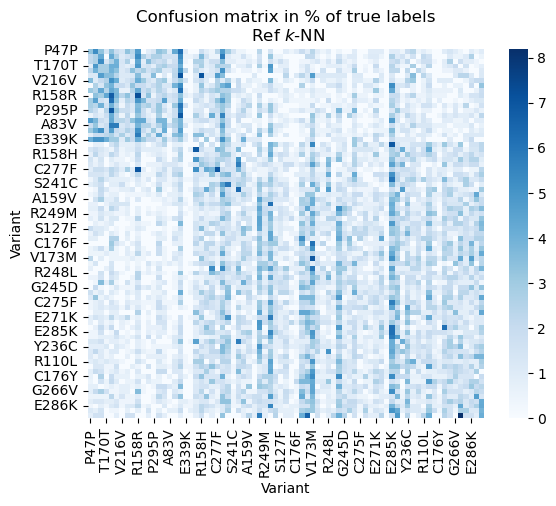

In [ ]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, index=dl_train.dataset.cats[sl], columns=dl_train.dataset.cats[sl])  
confusion.index.name = 'True label'
confusion.columns.name = 'Predicted label'

confusion = confusion.loc[fclass.index, fclass.index]

confusion = confusion.div(confusion.sum(axis=1), axis=0)*100

# seaborn plot
sns.heatmap(confusion.clip(0,15), annot=False, fmt='d', cmap='Blues',)
plt.title('Confusion matrix in % of true labels\n Ref $k$-NN')
plt.savefig(f'plots/scores/{run_name}/{run_name}_confusion_ref_knn.pdf')


(array([4.695e+03, 3.980e+02, 1.560e+02, 4.900e+01, 1.700e+01, 9.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0.        ,  3.45454545,  6.90909091, 10.36363636, 13.81818182,
        17.27272727, 20.72727273, 24.18181818, 27.63636364, 31.09090909,
        34.54545455]),
 <BarContainer object of 10 artists>)

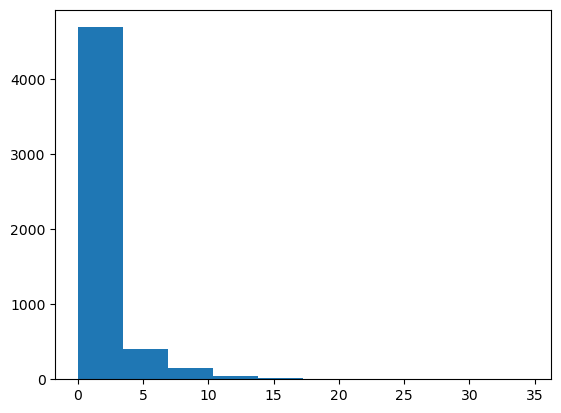

In [ ]:
plt.hist(confusion.to_numpy().flatten())

In [ ]:
pd.Series(np.diag(confusion), index = confusion.index).sort_values(ascending=False) 

True label
C277F    100.0
L344L     50.0
K132N     50.0
R273C     40.0
R158L     25.0
         ...  
G245V      0.0
R280K      0.0
C275Y      0.0
G266E      0.0
WT         0.0
Length: 75, dtype: float64

In [ ]:
run_name

'cls_tp53_mil_2norm_26'

Least confused variants :
- cls_tp53_0_best: C277F (25% !), R273C, R158R, V173M, R280K.
- cls_tp53_mil_2norm_26 (MIL, 50-cell bags): C277F (100% !), L344L, K132N, R273C, R158L

The presence of synonymous R158R in 3rd place makes me doubt the usefulness of this metric


Predicted variant  Impactful I  Impactful II   WT-like
True variant                                          
Impactful I           0.369697      0.509091  0.121212
Impactful II          0.093333      0.852963  0.053704
WT-like               0.035088      0.048246  0.916667


Text(0.5, 1.0, 'Confusion matrix in % of true labels\nRef $k$-NN')

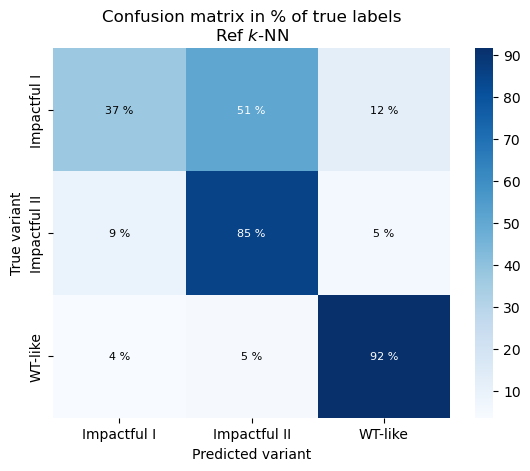

In [ ]:
confusion_fc = confusion.groupby(fclass).sum().T.groupby(fclass).sum().T
confusion_fc = confusion_fc.div(confusion_fc.sum(axis=1), axis=0)
confusion_fc.index.name = 'True variant'
confusion_fc.columns.name = 'Predicted variant'
sns.heatmap(confusion_fc*100, cmap='Blues', annot=False) #annot is bugged in seaborn 0.12.2
# manual annotate
for i in range(confusion_fc.shape[0]):
    for j in range(confusion_fc.shape[1]):
        plt.text(j+0.5, i+0.5, f'{confusion_fc.iloc[i,j]*100:.0f} %', ha='center', va='center', fontsize=8, 
                 color='white' if confusion_fc.iloc[i,j] > 0.5 else 'black')
print(confusion_fc)
plt.title('Confusion matrix in % of true labels\nRef $k$-NN')

## self knn

### Score

In [ ]:
subset = 'seen'
dl = dl_seen

model_ = model.network
device = 'cuda'
model_.eval()
model_ = model_.to(device)
embed, y_true, x_cell = [], [], []
for x,y in dl: # x,y are tuples of tensors of any size, we're taking the first one
    with torch.no_grad():
        embed.append(model_.embed(x[0].to(device)).cpu().squeeze())
        y_true.append(y[0])
        x0 = x[0].squeeze()
        if len(x[0].shape) > 2:
            x_cell.append(x0.mean(1))
        else:
            x_cell.append(x0)
embed = torch.concat(embed)
y_true = torch.concat(y_true)
x_red = PCA(20).fit_transform(torch.concat(x_cell))


In [ ]:
knn = KNeighborsTransformer(n_neighbors=k)
y_true = y_true.cpu().numpy()
knn.fit(embed.cpu(), )
graph = knn.kneighbors_graph()
y_pred = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred = y_pred.reshape((-1, k)) # (kN, ) -> (N, k)
y_pred = mode(y_pred.T).mode
s= accuracy_score(y_true, y_pred)

In [ ]:
knn.fit(x_red, )
graph = knn.kneighbors_graph()
y_pred_pca = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred_pca = y_pred_pca.reshape((-1, k)) # (kN, ) -> (N, k)
y_pred_pca = mode(y_pred_pca.T).mode
s_pca = accuracy_score(y_true, y_pred_pca)

In [ ]:
n_max = np.unique(y_true, return_counts=True)[1].max()
n_cell = len(y_true)
print(f'Score {s*100:.2f} % ({k}-nn). Best constant predictor : {100*n_max/n_cell:.2f} %. Score PCA : {s_pca*100:.2f} %')

Score 5.45 % (5-nn). Best constant predictor : 1.82 %. Score PCA : 5.09 %


### Confusion matrix

Text(0.5, 1.0, 'Confusion matrix in % of true labels\nself seen')

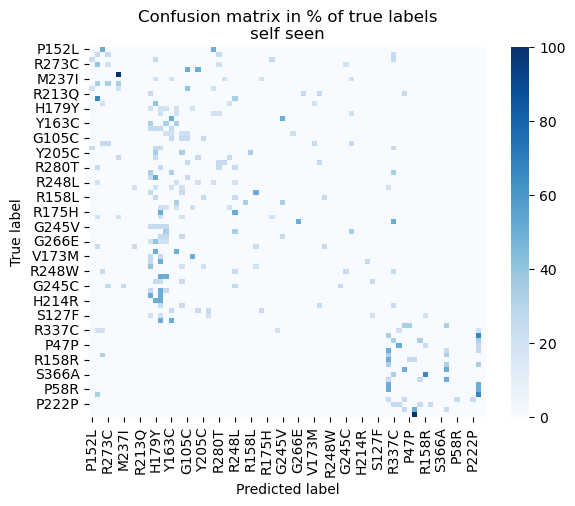

In [ ]:

confusion = confusion_matrix(y_true, y_pred)
confusion = pd.DataFrame(confusion, index=dl_train.dataset.cats[sl], columns=dl_train.dataset.cats[sl])  
confusion.index.name = 'True label'
confusion.columns.name = 'Predicted label'

confusion = pd.concat([group for _, group in confusion.groupby(fclass)])
confusion = pd.concat([group for _, group in confusion.T.groupby(fclass)]).T
confusion = confusion.div(confusion.sum(axis=1), axis=0)*100

# seaborn plot
sns.heatmap(confusion, annot=False, fmt='d', cmap='Blues',)
plt.title(f'Confusion matrix in % of true labels\nself {subset}')

In [ ]:
pd.Series(np.diag(confusion), index = confusion.index).sort_values(ascending=False) 

True label
C277F    100.0
L344L     50.0
R280K     25.0
G105C     25.0
R280T     25.0
         ...  
H179R      0.0
G245V      0.0
C275Y      0.0
G266E      0.0
WT         0.0
Length: 75, dtype: float64

## Most frequent variants

Now looking at self $k$-NN score on the subset of n most frequent variants (seen and unseen) with $k=3$ because the low number of points will make it impossible to get anything good with $k=5$

In [ ]:
seen_variants = [v for v in df_seen['variant'].unique() if v in MAIN_MUTANTS]
print("Seen variants : "+" ".join(seen_variants))
unseen_variants = [v for v in df_unseen['variant'].unique() if v in MAIN_MUTANTS]
print("Unseen variants : "+" ".join(unseen_variants))

Seen variants : R248W R282W H179R G245S R175H R273C WT
Unseen variants : R273H Y220C


In [ ]:
df = pd.concat([df_seen, df_unseen.sample(frac=0.25)]) # drop 3/4 of unseen to preserve balance with seen
df = df[df['variant'].isin(MAIN_MUTANTS)]
(dl,) = make_loaders(df, batch_size=64, dataset_class=dataset_class,n_workers=1,pos_frac=0.5, 
                  dataset_kwargs={'bag_size':BAG_SIZE})
model_ = model.network
device = 'cuda'
model_.eval()
model_ = model_.to(device)
embed, y_true, x_cell = [], [], []
for x,y in dl: # x,y are tuples of tensors of any size, we're taking the first one
    with torch.no_grad():
        embed.append(model_.embed(x[0].to(device)).cpu().squeeze())
        y_true.append(y[0])
        x0 = x[0].squeeze()
        if len(x[0].shape) > 2:
            x_cell.append(x0.mean(1))
        else:
            x_cell.append(x0)
embed = torch.concat(embed)
y_true = torch.concat(y_true)
x_red = PCA(20).fit_transform(torch.concat(x_cell)) #NB : this is not train set


(31, 50)


In [ ]:
knn = KNeighborsTransformer(n_neighbors=3)
y_true = y_true.cpu().numpy()
knn.fit(embed.cpu(), )
graph = knn.kneighbors_graph()
y_pred = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred = y_pred.reshape((-1, 3)) # (kN, ) -> (N, k)
y_pred = mode(y_pred.T).mode
s= accuracy_score(y_true, y_pred)

In [ ]:
knn.fit(x_red, )
graph = knn.kneighbors_graph()
y_pred_pca = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred_pca = y_pred_pca.reshape((-1, 3)) # (kN, ) -> (N, k)
y_pred_pca = mode(y_pred_pca.T).mode
s_pca = accuracy_score(y_true, y_pred_pca)

In [ ]:
np.unique(y_true, return_counts=True)

(array([ 5,  8, 23, 37, 40, 60, 74, 75, 94]),
 array([5, 4, 5, 4, 2, 4, 1, 2, 4]))

In [ ]:
n_max = np.unique(y_true, return_counts=True)[1].max()
n_cell = len(y_true)
print(f'Score {s*100:.2f} % (3-nn). Best constant predictor : {100*n_max/n_cell:.2f} %. Score PCA : {s_pca*100:.2f} %')

Score 22.58 % (3-nn). Best constant predictor : 16.13 %. Score PCA : 19.35 %


In [ ]:
emb_red = PCA(2).fit_transform(embed)

/tmp/ipykernel_4137798/651130670.py:3: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['variant'].cat.categories[y_true],
/tmp/ipykernel_4137798/651130670.py:3: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['variant'].cat.categories[y_true],


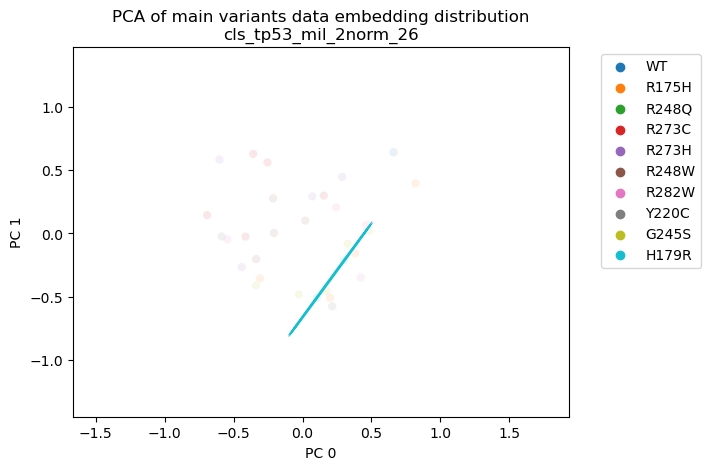

In [ ]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =df['variant'].cat.categories[y_true], 
                hue_order=MAIN_MUTANTS, alpha=0.1, legend=True)
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['variant'].cat.categories[y_true], 
            hue_order=MAIN_MUTANTS, levels=2, common_norm=True, )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
# put legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'PCA of main variants data embedding distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/mainvar_embed_pca_kde.pdf')

Text(0.5, 1.0, 'PCA of main variants data embedding distribution\ncls_tp53_mil_2norm_26')

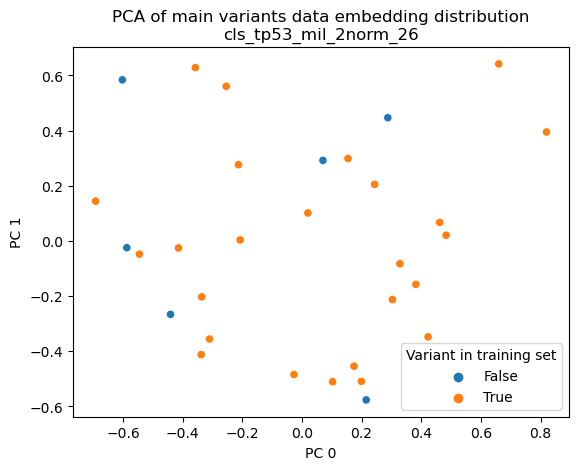

In [ ]:
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], 
                hue =df['variant'].cat.categories[y_true].isin(df_train.variant.unique()), 
                alpha=1, legend=True)
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['variant'].cat.categories[y_true], 
#             hue_order=MAIN_MUTANTS, levels=3, common_norm=False, )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
# put legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# rename legend
plt.legend(title='Variant in training set')
plt.title(f'PCA of main variants data embedding distribution\n{run_name}' )

# Training

In [ ]:
from tensorboard.backend.event_processing import event_accumulator

In [ ]:
ea = event_accumulator.EventAccumulator(f'runs/{run_dir}')

## Plotting training curves

In [ ]:
make_dir_if_needed('plots/runs')

In [ ]:
hue_order_sets = ['train','test_seen',
    # 'test_unseen'
    ]

In [ ]:
ea.Reload()

In [ ]:
ea.scalars.Keys()

['train/5_nn_self',
 'train/loss',
 'train/lr',
 'test_seen/5_nn_self',
 'test_seen/loss',
 'test_seen/5_nn_ref',
 'test_unseen/5_nn_self']

In [ ]:
# def get_df_from_tb(ea:event_accumulator.EventAccumulator, keys:List[str]=None) :
#     df = pd.DataFrame()
#     if keys is None:
#         keys = ea.scalars.Keys()
#     for key in keys:
#         events = ea.scalars.Items(key)
#         df[key] = pd.Series(data=[e.value for e in events], index=[e.step for e in events])
#     return df

In [ ]:
def get_df_from_tb(ea:event_accumulator.EventAccumulator, keys:List[str]=None) :
    df = []
    if keys is None:
        keys = ea.scalars.Keys()
    for key in keys:
        events = ea.scalars.Items(key)
        for e in events:
            data_set, variable = key.split('/')

            df.append({'data set':data_set, 'variable':variable, 'epoch':e.step,'value':e.value})
    return pd.DataFrame.from_records(df)

In [ ]:
df = get_df_from_tb(ea,)

In [ ]:
df

data set   variable  epoch     value
0           train  5_nn_self      0  0.013289
1           train  5_nn_self      1  0.132890
2           train  5_nn_self      2  0.139535
3           train  5_nn_self      3  0.157254
4           train  5_nn_self      4  0.261351
...           ...        ...    ...       ...
4195  test_unseen  5_nn_self    595  0.093525
4196  test_unseen  5_nn_self    596  0.067146
4197  test_unseen  5_nn_self    597  0.064748
4198  test_unseen  5_nn_self    598  0.079137
4199  test_unseen  5_nn_self    599  0.064748

[4200 rows x 4 columns]

In [ ]:
df = df[(df['data set']!='test_unseen')]

(-10.0, 200.0)

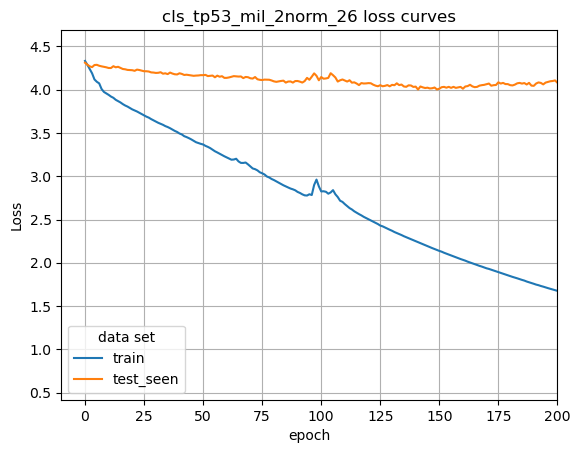

In [ ]:
sns.lineplot(df[(df.variable == 'loss')], x='epoch',y='value',hue='data set')
plt.title(f'{run_name} loss curves')
plt.ylabel('Loss')
# plt.yscale('logit')
plt.savefig(f'plots/runs/{run_name}_loss.pdf')
plt.grid()
plt.xlim([-10,200])


In [ ]:
df_smooth

NameError: name 'df_smooth' is not defined

# ROC Scores

## Intra-group

In [ ]:
subset = 'train'
group = 'Impactful II'
df = df_train

df = df[df['Variant functional class'] == group]

X = torch.tensor(df.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.embed(x))
embeds = torch.stack(embeds)

emb_red = pca.transform(embeds)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['variant'], levels=3, common_norm=False)
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} data embedding distribution ({group})\n{run_name}' )
# plt.savefig(f'plots/embeds/{run_name}/{subset}_{group}_embed_pca_kde.pdf')

In [ ]:
dl = DataLoader(SiameseDataset(df, p=0.5), batch_size=64, shuffle=True)
metrics = core_loop(dl, Siamese(model.network), SiameseLoss(margin=1, alpha=0), margin=1,  mode='test')
print(f'Metrics for {subset} data, {group=}')
pprint(metrics)

TypeError: core_loop() got an unexpected keyword argument 'margin'

## Inter-group

En chantier - je pense que ça fait plus de sens avec une metrique 1-nn que avec la ROC 

In [ ]:
subset = 'train'
group1 = 'Impactful I'
group2 = 'Impactful II'
df = df_train

df1 = df[df['Variant functional class'] == group1]
df2 = df[df['Variant functional class'] == group2]


In [ ]:
dl = DataLoader(
    BipartiteDataset(df1, df2, p1=0.5), # will always get 
    batch_size=64, shuffle=True,
)

In [ ]:
metrics = test_loop(dl, model, SiameseLoss(margin=1, alpha=0), device='cpu', margin=1)
print(f'Metrics for {subset} data, {group1=}, {group2=}')
pprint(metrics)

Metrics for train data, group1='Impactful I', group2='Impactful II'
{'_n_neg': 2754,
 '_n_pos': 2825,
 'dist_neg': 0.44673478603363037,
 'dist_pos': 0.37004172801971436,
 'l2_penalty': 0.0,
 'loss': 0.25942185605791485,
 'roc': 0.610097348690033}


# Draft stuff

In [ ]:
from contrastive_data import *  

In [ ]:
counts.groupby('variant').size()#.floordiv(5)

variant
A130V    1000
A146P    1000
A146T     946
A146V    1000
A155G     854
         ... 
V112I    1000
V14I      801
V14L     1000
V8V      1000
WT        644
Length: 97, dtype: int64

In [ ]:
ds = BatchBagDataset(counts)

In [ ]:
for t in ds:
    print(t)
    break

                         ZNF622      cycle variant Variant functional class
cell                                                                       
CATGACAGTAGCCTCG-1-28 -0.557781       G2.M   A130V                  WT-like
CGTAGGCCAGGGTTAG-1-1  -0.567613  Uncycling   A130V                  WT-like
CACACTCTCCACGTTC-1-19 -0.525162       G2.M   A130V                  WT-like
CAGAGAGCATGGGAAC-1-26 -0.382343       M.G1   A130V                  WT-like
GCATGCGAGCTGCGAA-1-1  -0.479597  Uncycling   A130V                  WT-like


KeyError: 'idx'

In [ ]:
counts.columns

Index(['A1BG', 'AATF', 'ABCA1', 'ABCC2', 'ABCD4', 'ABCG2', 'ABL2',
       'AC006262.4', 'AC006262.5', 'AC090498.1',
       ...
       'ZNF185', 'ZNF296', 'ZNF467', 'ZNF57', 'ZNF622', 'cycle', 'variant',
       'Variant functional class', 'index', 'idx'],
      dtype='object', length=1150)